In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#sys.path.append('C:\\Users\\elisa\\Documents\\git\\mplstereonet')
sys.path.append('../../..')
import mplstereonet
import gempy as gp
#from importlib import reload
import os
#sys.path.append('C:\\Users\\elisa\\Documents\\git\\remote-geomod')  # append local path to access rgeomod module
import pandas as pn

#import rgeomod

#import gdal
import skimage
import scipy
import linecache
from mpl_toolkits.mplot3d import Axes3D
from copy import copy

import seaborn as sns

../../../gempy/data_management.py:34: UserWarning: qgrid package is not installed. No interactive dataframes available.
  warnings.warn('qgrid package is not installed. No interactive dataframes available.')
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_4i3714ra.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce RTX 2080 (0000:01:00.0)
../../../gempy/posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../../gempy/posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulatio

In [2]:
number=1

In [3]:
path_interf = "all_points.csv"
path_orient = "Foliations_clust"+str(number)+".csv"

In [4]:
resolution = [50,50,50]
extent = np.array([777000, 794500, 6345000, 6353000, -1500, 1000])

In [5]:
geo_data = gp.create_data(extent = extent, resolution = resolution,
                        path_i = path_interf,
                        path_o = path_orient)

In [6]:
#sorting of lithologies
gp.set_series(geo_data,{'fault_NWSE':('fault_NWSE'),
                        'fault_NS':('fault_NS'),
                        'fault_NESW1':('fault_NESW1'),
                        'fault_NESW2':('fault_NESW2'),
                        'fault_NESW3':('fault_NESW3'),
                        'Trias_Series':('Liassic','Triassic'), 
                        'Carbon_Series':('Carboniferous'), 
                        'Basement_Series':('basement')},
             order_formations=['fault_NWSE','fault_NS',
                                'fault_NESW1','fault_NESW3','fault_NESW2',
                               'Liassic','Triassic','Carboniferous','basement'])

In [7]:
colordict = {'Liassic':'#015482', 'Triassic': '#9f0052', 'Carboniferous':'#ffbe00','basement':'#728f02',
            'fault_NWSE':'#2a2a2a','fault_NS':'#2a2a2a','fault_NESW2':'#939393','fault_NESW1':'#939393',
             'fault_NESW3':'#939393','fault_NESW4':'#939393' }
geo_data.set_colors(colordict)

,value,formation_number,color
fault_NWSE,1,1,#2a2a2a
fault_NS,2,2,#2a2a2a
fault_NESW1,3,3,#939393
fault_NESW3,4,4,#939393
fault_NESW2,5,5,#939393
Liassic,6,6,#015482
Triassic,7,7,#9f0052
Carboniferous,8,8,#ffbe00
basement,9,9,#728f02


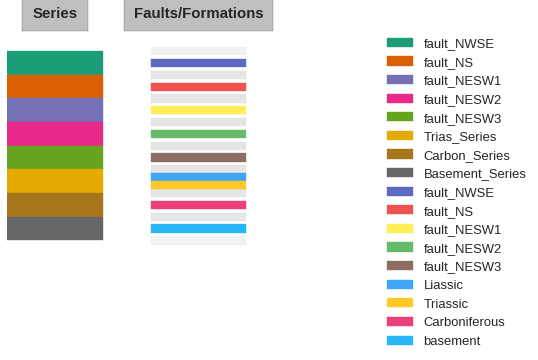

In [8]:
gp.get_sequential_pile(geo_data)

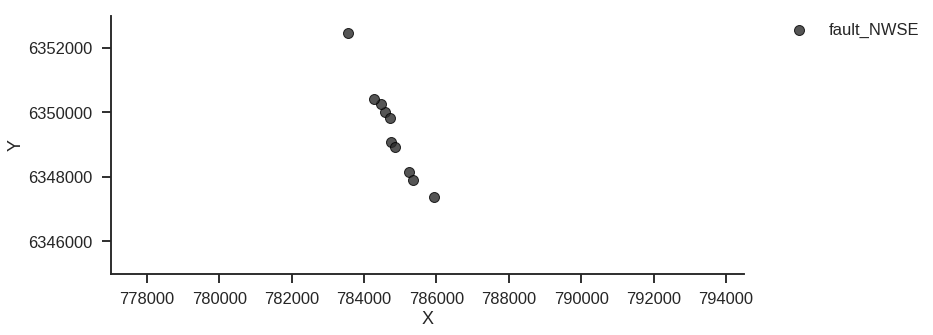

In [9]:
gp.plotting.plot_data(geo_data,direction='z',data_type='interfaces',series='fault_NWSE')
#plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\clusteredorient_only.png", format='png', dpi=1000)

In [10]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  dtype='float32',theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cuda
Precision:  float32
Number of faults:  5


### Choosing which series a fault offsets

In [11]:
faults1=['fault_NESW1',
 'fault_NESW2',
 'fault_NESW3']
faults2=['fault_NS',
 'fault_NWSE']

In [12]:
geo_data.faults_relations.loc[faults1,['Trias_Series']] = True
geo_data.faults_relations.loc[faults2,['Trias_Series']] = True
geo_data.faults_relations.loc[faults2,['Carbon_Series']] = True
geo_data.faults_relations

,fault_NWSE,fault_NS,fault_NESW1,fault_NESW2,fault_NESW3,Trias_Series,Carbon_Series,Basement_Series
fault_NWSE,False,False,False,False,False,True,True,False
fault_NS,False,False,False,False,False,True,True,False
fault_NESW1,False,False,False,False,False,True,False,False
fault_NESW2,False,False,False,False,False,True,False,False
fault_NESW3,False,False,False,False,False,True,False,False
Trias_Series,False,False,False,False,False,False,False,False
Carbon_Series,False,False,False,False,False,False,False,False
Basement_Series,False,False,False,False,False,False,False,False


In [13]:
interp_data.update_interpolator(geo_data)

CPU 1 core = 2,63

GPU = ,12

In [15]:
lith_block, fault_block = gp.compute_model(interp_data)

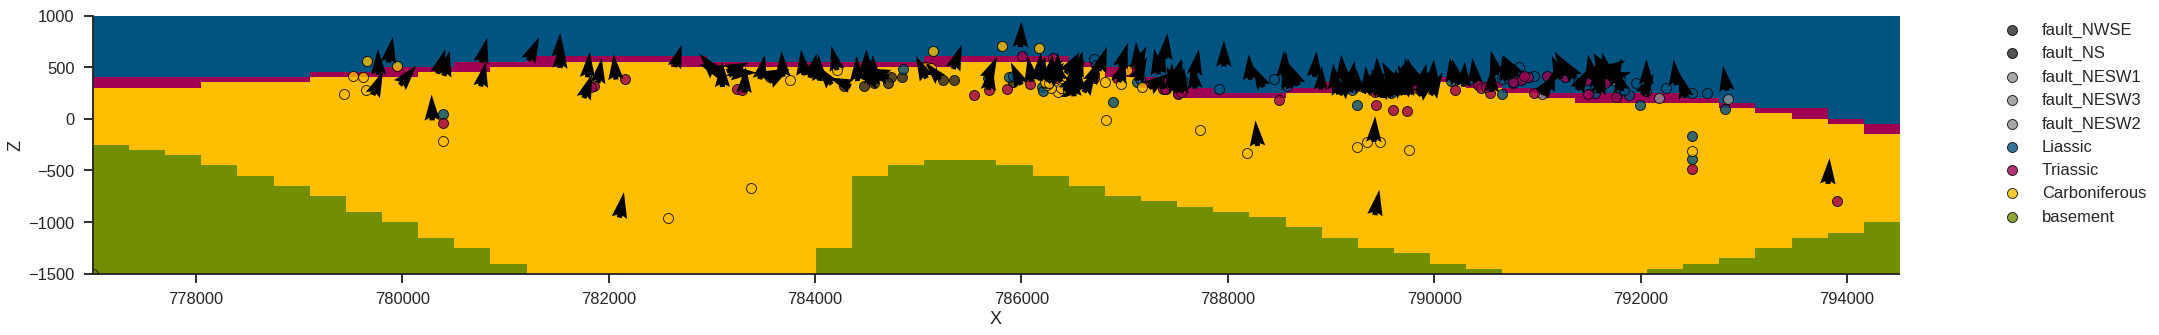

In [16]:
gp.plot_section(geo_data, lith_block[0], 25, plot_data=True)

## Adding topography

In [17]:
topo_plotting = np.load('topo_plotting.npy')

../../../gempy/utils/topography.py:24: UserWarning: gdal package is not installed. No support for raster functions
  warnings.warn("gdal package is not installed. No support for raster functions")


Define path to raster file
(50, 50)


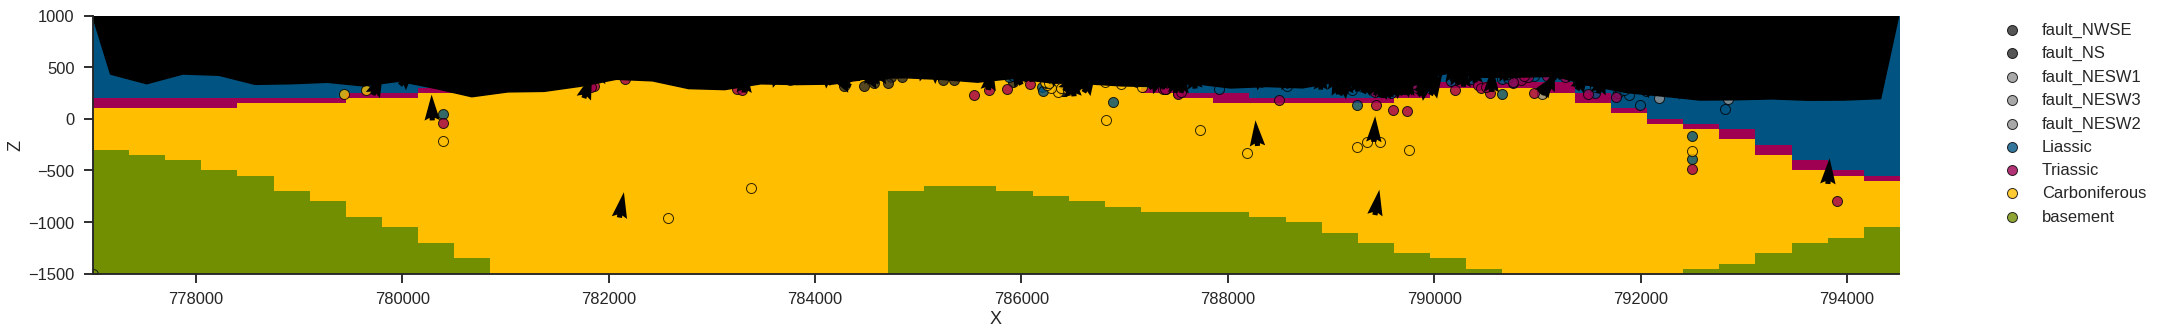

In [18]:
from gempy.utils import topography
elevation = topography.DEM(xyzarray=topo_plotting, geodata=geo_data)#,output_path = folder,interpdata=interp_data)
gp.plot_section(geo_data, lith_block[0], 18, plot_data=True, topography=elevation)

#### GeologicalMap

In [19]:
# We stack the topograghy and the regular grid values
topo_data = np.load('surface_coordinates.npy')
x_to_int = np.vstack((topo_data, geo_data.grid.values))

In [20]:
lith_complete, _ = gp.compute_model_at(x_to_int, interp_data)
lith_map = lith_complete[0][:320*700]
lith_mesh = lith_complete[0][320*700:]

##### Plot section of the mesh

(50, 50)


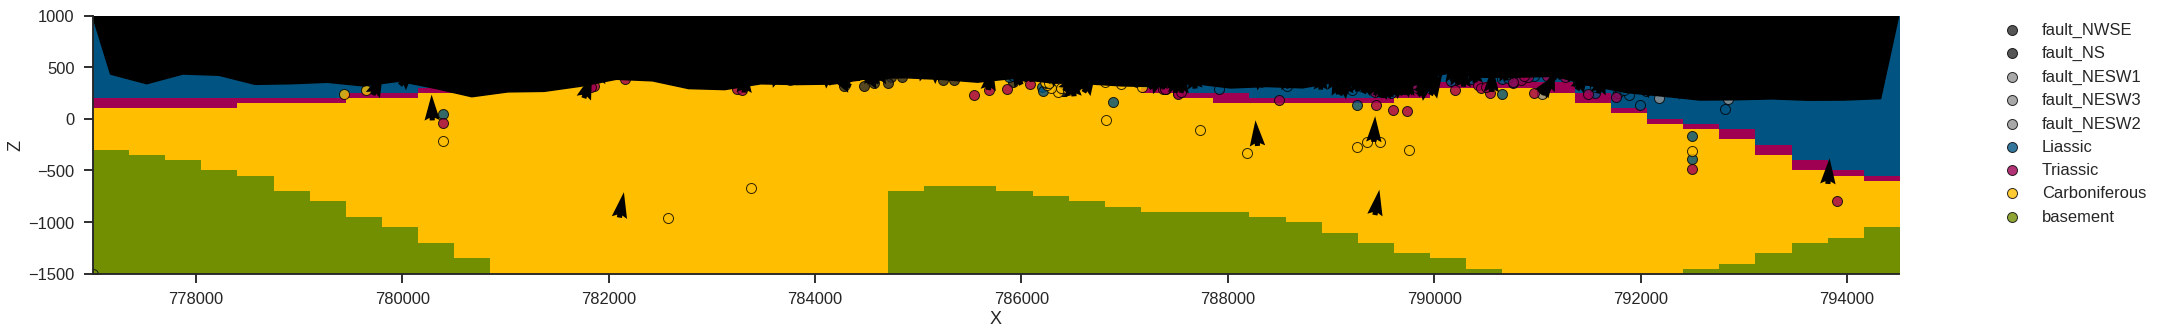

In [21]:
gp.plot_section(geo_data, lith_mesh, 18, plot_data=True, topography=elevation)

##### Plot geological map

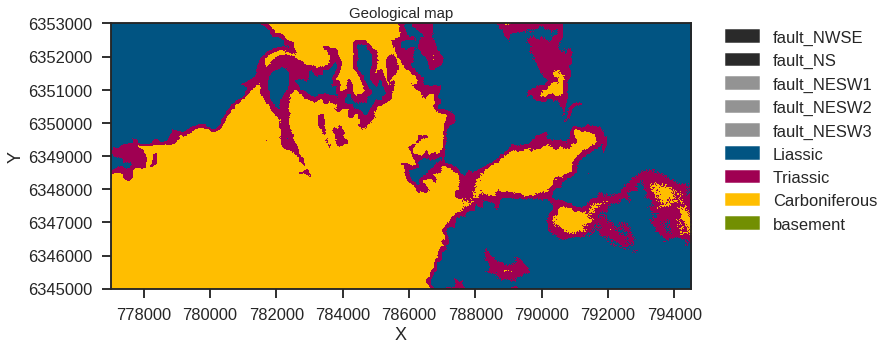

In [22]:
gp.plotting.plot_map(geo_data, geomap=lith_map.reshape(320,700))


### Creating vMF distributions for each orientation

In [23]:
import gempy.utils.fishdist as fish
vMF_list = []
for e, i in geo_data.orientations[['G_x', 'G_y', 'G_z', 'kappa']].iterrows():
   # print(i[['G_x', 'G_y', 'G_z']].values)
    vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=i['kappa']))
    


for some purposes spherecluster package would be good (or I copy the respective file?!


The next two cells are the ones we need to loop

In [24]:
# Now we can sample by calling the following
new_orientations = np.vstack(list(map(lambda x: x.sample(num_samples=1, direct_output=True)[0], vMF_list) ))
# Modifing the rescale dataframe
interp_data.geo_data_res.orientations[['G_x', 'G_y', 'G_z']] = new_orientations
interp_data.geo_data_res.calculate_orientations()
# Preparing the rescale data for theano because of the stupid basement
# shame on me that this is the librarz

In [26]:
interp_data.update_interpolator(geo_data)
lith_complete, _ = gp.compute_model_at(x_to_int, interp_data)
lith_map = lith_complete[0][:320*700]
lith_mesh = lith_complete[0][320*700:]

272 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Probability field function

In [ ]:
# your code is here:

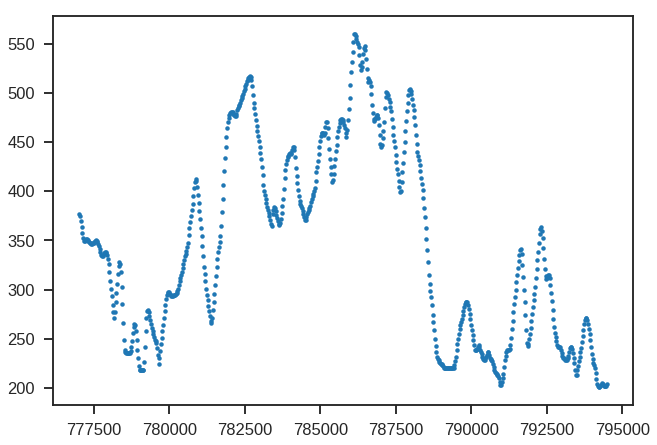

In [30]:
plt.plot(topography[:, 0].reshape(320,700)[160, :],
    topography[:, 2].reshape(320,700)[160, :], '.')

In [31]:
lith_map, _ = gp.compute_model_at(topography, interp_data)

In [32]:
topography

array([[7.7701250e+05, 6.3529875e+06, 3.4900000e+02],
       [7.7703750e+05, 6.3529875e+06, 3.4300000e+02],
       [7.7706250e+05, 6.3529875e+06, 3.4200000e+02],
       ...,
       [7.9443750e+05, 6.3450125e+06, 1.8900000e+02],
       [7.9446250e+05, 6.3450125e+06, 1.8900000e+02],
       [7.9448750e+05, 6.3450125e+06, 1.8900000e+02]])

In [33]:
geo_data.grid.values

array([[ 7.77175e+05,  6.34508e+06, -1.47500e+03],
       [ 7.77175e+05,  6.34508e+06, -1.42500e+03],
       [ 7.77175e+05,  6.34508e+06, -1.37500e+03],
       ...,
       [ 7.94325e+05,  6.35292e+06,  8.75000e+02],
       [ 7.94325e+05,  6.35292e+06,  9.25000e+02],
       [ 7.94325e+05,  6.35292e+06,  9.75000e+02]], dtype=float32)

In [34]:
res_top = interp_data.interpolator.tg.grid_val_T.get_value()

In [35]:
res_reg = interp_data.interpolator.tg.grid_val_T.get_value()

In [36]:
res_reg[:-310][:,0].max()

0.7583649575380434

In [37]:

plt.imshow(res_reg[:-310, 2].reshape(50,50,50)[:,25,:].T,
           extent=(res_reg[:-310][:,0].min(),
                   res_reg[:-310][:,0].max(),
                   res_reg[:-310][:,2].min(),
                   res_reg[:-310][:,2].max()))
plt.plot(res_top[:-310, 0].reshape(320,700)[160, :],
    res_top[:-310, 2].reshape(320,700)[160, :], '.')

ValueError: cannot reshape array of size 224000 into shape (50,50,50)

In [ ]:
lith_map[1]

In [ ]:
interp_data.potential_at_interfaces

In [ ]:
geo_data.formations

In [ ]:
topography = np.load('surface_coordinates.npy')
topography[:, 2] -= 0 

In [42]:
a = np.vstack((topography, geo_data.grid.values))

In [43]:
interp_data.update_interpolator()
lith_map, _ = gp.compute_model_at(a, interp_data)

In [ ]:
lith_block[1].min(), lith_block[1].max()

In [ ]:
plt.hist(lith_block[1][lith_block[1]<-15])

In [ ]:
boundary_pad = (max_pot - min_pot)*0.1

In [ ]:
interp_data.potential_at_interfaces

In [ ]:
plt.hist(lith_map[0])

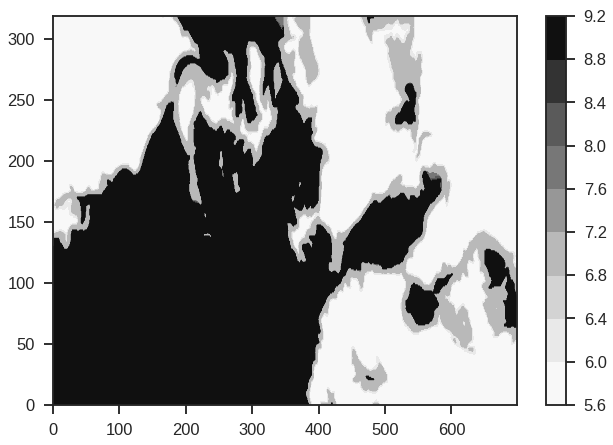

In [38]:
plt.contourf(lith_map[0].reshape(320, 700))
plt.colorbar()

In [44]:
320 * 700

224000

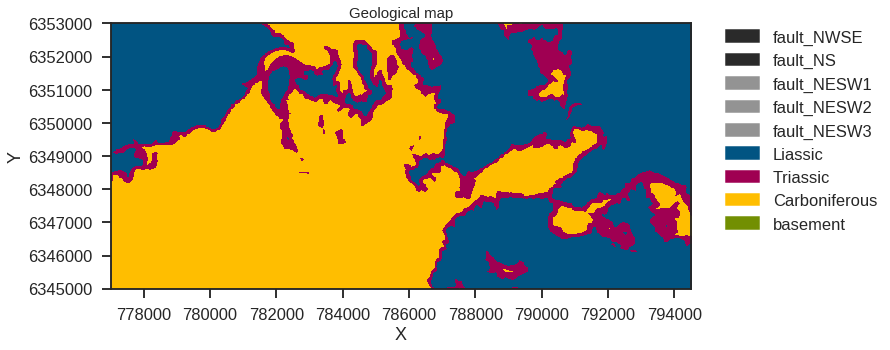

In [45]:
gp.plotting.plot_map(geo_data, geomap=lith_map[0][:224000].reshape(320,700))


### Topography

In [13]:
#topography
path_dtm='C:\\Users\\elisa\\Documents\\Ales\\DISTRIB_2018\\MNT\\MNT_Dx25m_ALES_L93.asc'
folder= "C:\\Users\\elisa\\Documents\\git\\MSc\\GempyTopography\\unwichtig"
xyz_path = "C:\\Users\\elisa\\Documents\\git\\MSc\\GempyTopography\\XYZ.csv"

In [ ]:
elevation = topography.DEM(path_dtm, geo_data,output_path = folder,interpdata=interp_data)

In [ ]:
xmap = elevation.xyz_box_resized[:,:,0].ravel()
ymap = elevation.xyz_box_resized[:,:,1].ravel()
zmap = elevation.xyz_box_resized[:,:,2].ravel()
elevation_resized = np.stack((xmap,ymap,zmap),axis=1)

In [ ]:
lith_map, fault_map = gp.compute_model_at(elevation_resized, interp_data)

In [ ]:
gp.plotting.plot_map(geo_data, geomap=lith_map[0].reshape(50,50))
#gp.plotting.extract_countours(geo_data,interp_data, fb=fault_map, cell_number=0)

In [13]:
lith_map, fault_map = gp.compute_model_at(elevation.surface_coordinates[0], interp_data)

In [14]:
import matplotlib

In [17]:
def extract_countours(interp_data, fb,lb=None):   
    lith_colors = ['#000000','#000000','#000000','#000000','#000000']
    cm = matplotlib.colors.LinearSegmentedColormap.from_list('lith_colors', lith_colors, N=5)
    
    n_faults = int(fb.shape[0]/2)
    level = []
    block_id=[]
    
    all_levels = interp_data.potential_at_interfaces[np.where(interp_data.potential_at_interfaces != 0)]
    
    for i in range(fb.shape[0]):
        if i%2:
            block_id.append(i)
    
    for i in range(len(block_id)):
        cp = plt.contour(np.flip(fb[block_id[i]].reshape(320, 700),axis=0),0,
            extent=geo_data.extent[[0,1,2,3]],levels=all_levels[i], cmap=cm)
    if lb is not None:
        cp2 = plt.contour(np.flip(lb[block_id[i]].reshape(320, 700),axis=0),0,
                extent=geo_data.extent[[0,1,2,3]],levels=np.sort(all_levels[len(block_id):]),cmap=cm)

#print(all_levels) 
    

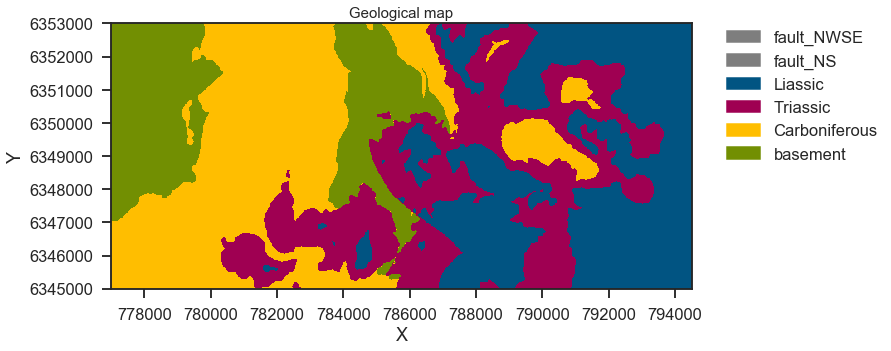

In [97]:
gp.plotting.plot_map(geo_data, geomap=np.flip(lith_map[0].reshape(320, 700),axis=0))
#extract_countours(interp_data,fault_map)
plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\map_filtered_b2.png", format='png', dpi=1000)

In [43]:
#lith_block, fault_block = gp.compute_model(interp_data)

In [13]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,...,formation_number,order_series,isFault,Unnamed: 0,beta,index,kappa,n_points,annotations,formation_value
0,784621.048000,6.350057e+06,357.440542,-9.106174e-01,-2.319442e-01,0.342020,70.000000,255.71,1,fault_NWSE,...,1,1,True,716,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1
1,783639.818000,6.352490e+06,408.343143,-9.254166e-01,-3.368241e-01,0.173648,80.000000,250.00,1,fault_NWSE,...,1,1,True,713,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},1}$",1
2,784714.333000,6.349362e+06,404.256019,-9.361168e-01,-8.189961e-02,0.342020,70.000000,265.00,1,fault_NWSE,...,1,1,True,715,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},2}$",1
3,784347.374000,6.350359e+06,316.354856,-8.443743e-01,-4.123763e-01,0.342020,70.000000,243.97,1,fault_NWSE,...,1,1,True,714,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},3}$",1
4,786416.757671,6.351491e+06,270.371423,5.265408e-01,3.686878e-01,0.766044,40.000000,55.00,1,fault_NS,...,2,2,True,712,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{2}},0}$",2
5,791031.228000,6.345650e+06,241.782365,6.000939e-01,-2.303545e-01,0.766044,40.000000,111.00,1,fault_NESW1,...,3,3,True,709,NaN,NaN,100.000000,NaN,"${\bf{x}}_{\beta \,{\bf{3}},0}$",3
6,791639.175000,6.349891e+06,443.273715,8.528685e-01,-1.503837e-01,0.500000,60.000000,100.00,1,fault_NESW2,...,5,4,True,710,NaN,NaN,100.000000,NaN,"${\bf{x}}_{\beta \,{\bf{5}},0}$",5
7,791682.282000,6.350183e+06,387.023171,9.076734e-01,-3.303661e-01,0.258819,75.000000,110.00,1,fault_NESW3,...,4,5,True,711,NaN,NaN,100.000000,NaN,"${\bf{x}}_{\beta \,{\bf{4}},0}$",4
8,792055.627853,6.350019e+06,335.647351,1.000030e-12,-2.419219e-01,0.970296,14.000000,180.00,1,Liassic,...,6,6,False,88,666.000000,67.0,666.000000,3.0,"${\bf{x}}_{\beta \,{\bf{6}},0}$",6
9,791683.582213,6.349840e+06,434.401739,-5.735764e-01,9.998946e-13,0.819152,35.000000,270.00,1,Liassic,...,6,6,False,89,666.000000,68.0,666.000000,4.0,"${\bf{x}}_{\beta \,{\bf{6}},1}$",6


### Setting up pymc functions

In [14]:
import pymc
import copy

In [15]:
# to sample from a vMF distribution
from gempy.utils.fishdist import vMF

for some purposes spherecluster package would be good (or I copy the respective file?!


In [16]:
import gempy.utils.fishdist as fish

In [17]:
# make a copy of the initial dataframe
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)

In [18]:
geo_data_const = copy.deepcopy(interp_data.geo_data_res)

In [19]:
# define number of model iterations
n_iter = 30

In [20]:
#this is for indexing of the sampled orientations (vMF not in PyMC available)
orient_modifier = pymc.Uniform('stoch_orient',0,n_iter) 

In [21]:
### define which lithologies to be uncertain ###

#inputdat = 'faults'
inputdat = 'all'

In [24]:
geo_data.orientations

,X,Y,Z,G_x,G_y,G_z,dip,azimuth,polarity,formation,...,formation_number,order_series,isFault,Unnamed: 0,beta,index,kappa,n_points,annotations,formation_value
0,784621.048000,6.350057e+06,357.440542,-9.106174e-01,-2.319442e-01,0.342020,70.000000,255.71,1,fault_NWSE,...,1,1,True,716,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},0}$",1
1,783639.818000,6.352490e+06,408.343143,-9.254166e-01,-3.368241e-01,0.173648,80.000000,250.00,1,fault_NWSE,...,1,1,True,713,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},1}$",1
2,784714.333000,6.349362e+06,404.256019,-9.361168e-01,-8.189961e-02,0.342020,70.000000,265.00,1,fault_NWSE,...,1,1,True,715,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},2}$",1
3,784347.374000,6.350359e+06,316.354856,-8.443743e-01,-4.123763e-01,0.342020,70.000000,243.97,1,fault_NWSE,...,1,1,True,714,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{1}},3}$",1
4,786416.757671,6.351491e+06,270.371423,5.265408e-01,3.686878e-01,0.766044,40.000000,55.00,1,fault_NS,...,2,2,True,712,NaN,NaN,30.000000,NaN,"${\bf{x}}_{\beta \,{\bf{2}},0}$",2
5,791031.228000,6.345650e+06,241.782365,6.000939e-01,-2.303545e-01,0.766044,40.000000,111.00,1,fault_NESW1,...,3,3,True,709,NaN,NaN,100.000000,NaN,"${\bf{x}}_{\beta \,{\bf{3}},0}$",3
6,791639.175000,6.349891e+06,443.273715,8.528685e-01,-1.503837e-01,0.500000,60.000000,100.00,1,fault_NESW2,...,5,4,True,710,NaN,NaN,100.000000,NaN,"${\bf{x}}_{\beta \,{\bf{5}},0}$",5
7,791682.282000,6.350183e+06,387.023171,9.076734e-01,-3.303661e-01,0.258819,75.000000,110.00,1,fault_NESW3,...,4,5,True,711,NaN,NaN,100.000000,NaN,"${\bf{x}}_{\beta \,{\bf{4}},0}$",4
8,792055.627853,6.350019e+06,335.647351,1.000030e-12,-2.419219e-01,0.970296,14.000000,180.00,1,Liassic,...,6,6,False,88,666.000000,67.0,666.000000,3.0,"${\bf{x}}_{\beta \,{\bf{6}},0}$",6
9,791683.582213,6.349840e+06,434.401739,-5.735764e-01,9.998946e-13,0.819152,35.000000,270.00,1,Liassic,...,6,6,False,89,666.000000,68.0,666.000000,4.0,"${\bf{x}}_{\beta \,{\bf{6}},1}$",6


In [86]:
geo_data.orientations[['G_x', 'G_y', 'G_z', 'kappa']].iterrows()

<generator object DataFrame.iterrows at 0x7fa49cf96b48>

In [100]:
vMF_list = []
for e, i in geo_data.orientations[['G_x', 'G_y', 'G_z', 'kappa']].iterrows():
   # print(i[['G_x', 'G_y', 'G_z']].values)
    vMF_list.append(fish.vMF('vMF_' + str(e), mean=i[['G_x', 'G_y', 'G_z']].values, kappa=i['kappa']))
    
np.vstack(list(map(lambda x: x.sample(num_samples=1, direct_output=True)[0], vMF_list) ))    

In [123]:
np.vstack(list(map(lambda x: x.sample(num_samples=1, direct_output=True)[0], vMF_list) ))

array([[-8.33780694e-01, -2.22866251e-01,  5.05114232e-01],
       [-9.72933171e-01,  1.17276393e-01,  1.99116280e-01],
       [-9.85324187e-01, -1.07265468e-02,  1.70356064e-01],
       [-5.55801737e-01, -6.91144656e-01,  4.61956160e-01],
       [ 2.83360389e-01,  2.45497479e-01,  9.27058724e-01],
       [ 5.60417558e-01, -1.35503286e-01,  8.17050194e-01],
       [ 9.16408995e-01,  6.45462623e-04,  4.00242598e-01],
       [ 8.70329675e-01, -2.87396351e-01,  3.99911982e-01],
       [ 2.57234991e-02, -2.13610392e-01,  9.76580208e-01],
       [-5.38237269e-01,  3.50711230e-02,  8.42063334e-01],
       [ 1.69911134e-01, -5.09225339e-02,  9.84142826e-01],
       [-1.07537969e-01, -1.54145794e-01,  9.82178527e-01],
       [ 2.44092498e-01, -6.76158787e-02,  9.67391826e-01],
       [-2.60724670e-02,  1.72608677e-01,  9.84645353e-01],
       [-5.71017996e-02, -3.44011754e-01,  9.37227452e-01],
       [-2.54003842e-01,  7.59242116e-02,  9.64218628e-01],
       [-2.50146983e-01, -8.56842344e-02

In [107]:
geo_data.orientations[['G_x', 'G_y', 'G_z']]

,G_x,G_y,G_z
0,-9.106174e-01,-2.319442e-01,0.342020
1,-9.254166e-01,-3.368241e-01,0.173648
2,-9.361168e-01,-8.189961e-02,0.342020
3,-8.443743e-01,-4.123763e-01,0.342020
4,5.265408e-01,3.686878e-01,0.766044
5,6.000939e-01,-2.303545e-01,0.766044
6,8.528685e-01,-1.503837e-01,0.500000
7,9.076734e-01,-3.303661e-01,0.258819
8,1.000030e-12,-2.419219e-01,0.970296
9,-5.735764e-01,9.998946e-13,0.819152


In [56]:
# only fault uncertainty
if inputdat == 'faults':
    @pymc.deterministic(trace=True)
    def input_data(value=0,geo_data_const=geo_data_const,
                   geo_data_stoch_init = geo_data_stoch_init, orient_modifier = orient_modifier):

        geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
        #print(geo_data_stoch.shape)
        geo_data_stoch_orient = geo_data_stoch_init.orientations[["X", "Y", "Z","G_x", "G_y", "G_z","formation",'kappa',
                                               'dip', 'azimuth', 'polarity','isFault']]

        fault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == True]
        means = geo_data_const.orientations[geo_data_const.orientations['isFault'] == True][['G_x','G_y','G_z']]
        notfault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == False]

        for i in fault_df.index:
           
            mean = means.loc[i]
            form = geo_data_stoch_orient.loc[i]['formation']
            kappa = geo_data_stoch_orient.loc[i]['kappa']

            fish = vMF(mean = mean, kappa = kappa)
            #print(fish.mean)
            xyz, azdip = fish.sample(direct_output=True,num_samples=n_iter)

            fault_df.loc[i, ['G_x','G_y','G_z']] = xyz[int(orient_modifier)]
            fault_df.loc[i, ['azimuth','dip']] = azdip[int(orient_modifier)]

        geo_orientations = pn.concat((fault_df,notfault_df))
        geo_orient = geo_orientations[["X", "Y", "Z","G_x", "G_y", "G_z", 'dip', 'azimuth', 'polarity']]
        #print(geo_orientations)
        return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_orient]
    
    
elif inputdat == 'all':
        # all uncertainty values of df
    @pymc.deterministic(trace=True)
    def input_data(value=0,geo_data_const=geo_data_const,
                   geo_data_stoch_init = geo_data_stoch_init, orient_modifier = orient_modifier):

        geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
        #print(geo_data_stoch.shape)
        geo_data_stoch_orient = geo_data_stoch_init.orientations[["X", "Y", "Z","G_x", "G_y", "G_z","formation",'kappa',
                                               'dip', 'azimuth', 'polarity','isFault']]
        
        means = geo_data_const.orientations[['G_x','G_y','G_z']]
        #fault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == True]
        #notfault_df = geo_data_stoch_orient[geo_data_stoch_orient['isFault'] == False]
        
        for i in geo_data_stoch_orient.index:

            mean = means.loc[i]
            form = geo_data_stoch_orient.loc[i]['formation']
            kappa = geo_data_stoch_orient.loc[i]['kappa']

            fish = vMF(mean = mean, kappa = kappa)
            #print(fish.mean)
            xyz, azdip = fish.sample(direct_output=True,num_samples=n_iter)

            geo_data_stoch_orient.loc[i, ['G_x','G_y','G_z']] = xyz[int(orient_modifier)]
            geo_data_stoch_orient.loc[i, ['azimuth','dip']] = azdip[int(orient_modifier)]

        #geo_orientations = pn.concat((fault_df,notfault_df))
        geo_orient = geo_data_stoch_orient[["X", "Y", "Z", "G_x", "G_y", "G_z", 'dip', 'azimuth', 'polarity']]
        #print(geo_orientations)
        return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_orient]

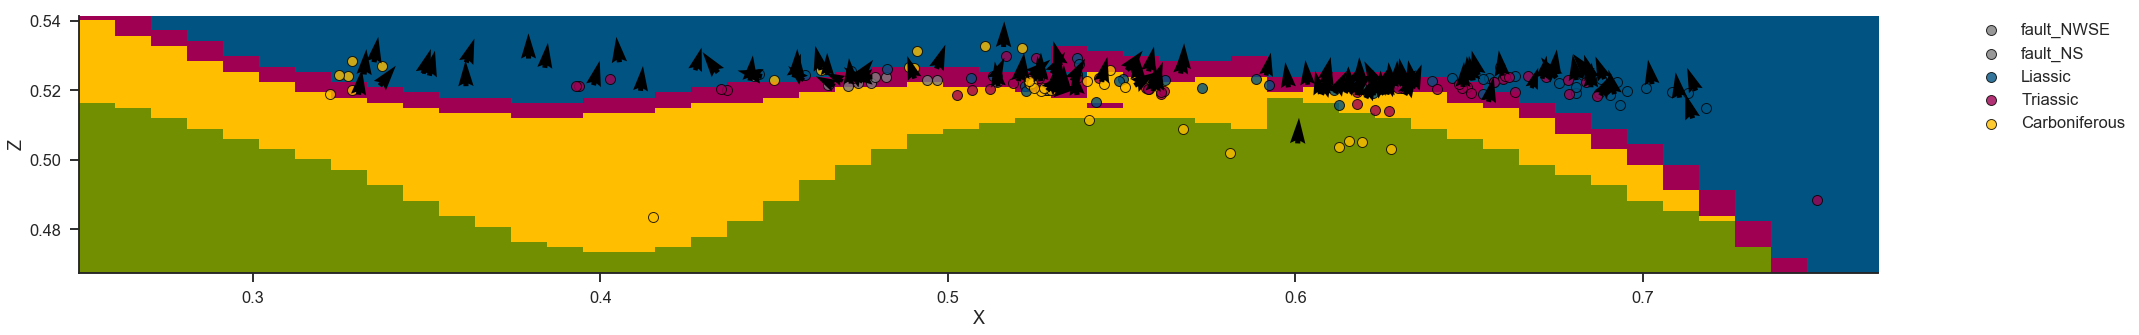

In [57]:
@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=True):
    
    # modify input data values accordingly
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]

    interp_data.geo_data_res.orientations[["X", "Y", "Z","G_x", "G_y", "G_z", 
                                           'dip', 'azimuth', 'polarity']] = input_data[1] 

    try:
        # try to compute model
        lb, fb = gp.compute_model(interp_data)
        #print(lb)
        if True:
            gp.plot_section(interp_data.geo_data_res, lb[0], 0, direction = 'y',plot_data=True)
            #print(interp_data.geo_data_res.interfaces["X"]) 
            
            return lb,fb

    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
            return np.zeros_like(lith_block), np.zeros_like(fault_block)

In [58]:
params = [input_data, gempy_model,orient_modifier] 
model = pymc.Model(params)

In [59]:
dbname = "C:\\Users\\elisa\\Documents\\git\\elthesis\\notebooks\\databases\\final\\Model3_filt_1102_i"+str(n_iter)+".hdf5"

In [60]:
dbname

'C:\\Users\\elisa\\Documents\\git\\elthesis\\notebooks\\databases\\final\\Model3_filt_1102_i30.hdf5'

In [61]:
RUN = pymc.MCMC(model, db="hdf5",dbname = dbname)

In [62]:
RUN.sample(iter=n_iter, verbose=0)

 [--                6%                  ] 2 of 30 complete in 2.3 sec[---              10%                  ] 3 of 30 complete in 4.6 sec[-----            13%                  ] 4 of 30 complete in 6.8 sec[------           16%                  ] 5 of 30 complete in 9.0 sec[-------          20%                  ] 6 of 30 complete in 11.1 sec[--------         23%                  ] 7 of 30 complete in 13.3 sec[----------       26%                  ] 8 of 30 complete in 15.5 sec[-----------      30%                  ] 9 of 30 complete in 17.7 sec[------------     33%                  ] 10 of 30 complete in 20.1 sec[-------------    36%                  ] 11 of 30 complete in 22.3 sec[---------------  40%                  ] 12 of 30 complete in 24.5 sec[---------------- 43%                  ] 13 of 30 complete in 26.6 sec[-----------------46%                  ] 14 of 30 complete in 28.9 sec[-----------------50%                  ] 15 of 30 complete in 31.1 sec[-----------------53%          

### Posterior

In [63]:
import importlib
importlib.reload(gp.posterior_analysis_elisa )

<module 'gempy.posterior_analysis_elisa' from 'C:\\Users\\elisa\\Documents\\git\\gempy\\gempy\\posterior_analysis_elisa.py'>

In [64]:
from gempy.posterior_analysis_elisa import Posterior

In [65]:
post = Posterior(dbname,entropy=True,interpdata=interp_data,geodata=geo_data, topography=elevation)

Lithology probability for all post models are calculated. Based on the model complexity and the number of iterations, this could take a while


In [74]:
norm = matplotlib.colors.Normalize(post.map_ie.min(),post.map_ie.max())

In [73]:
post.map_ie.max(),post.map_ie.min()

(1.7539845481434939, 0.0)

In [93]:
iemap=np.flip(post.map_ie.reshape(320, 700),axis=0)
iemap2=post.map_ie.reshape(320, 700)

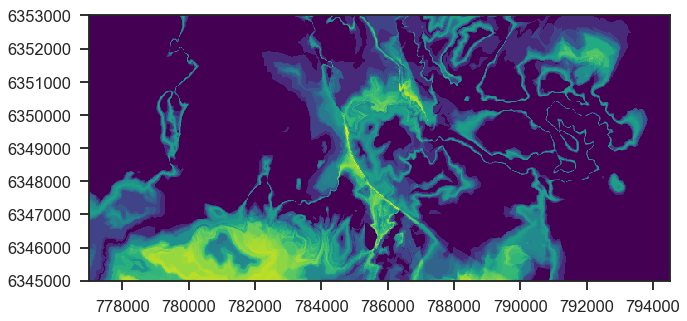

In [99]:
plt.imshow(iemap2,cmap='viridis',extent=geo_data.extent[:4])
plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\map_entropyflip2.png", format='png', dpi=1000)

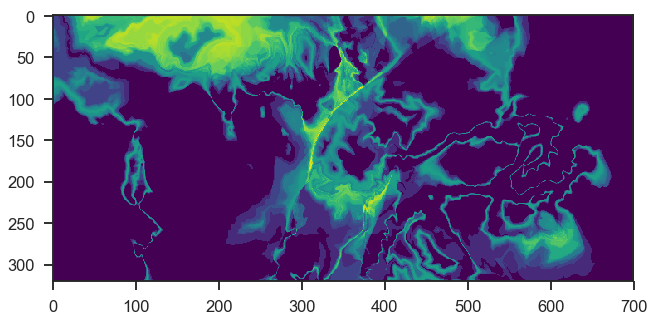

In [86]:
#gp.plotting.plot_data(geo_data,direction='z')
plt.imshow(iemap,cmap='viridis')
#plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\map_entropy.png", format='png', dpi=1000)

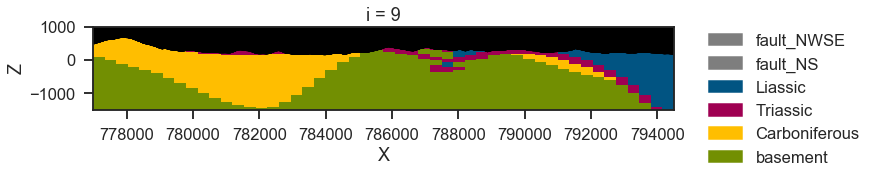

In [92]:
for i in range(0,10):
    post.plot_section(iteration=i,block='lith',fault=False)
    plt.title("i = %.d"%i)
    plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\post_y25_nofault"+str(i))

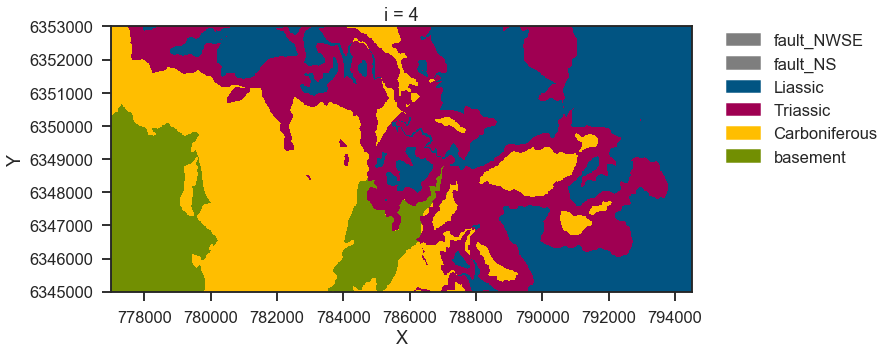

In [101]:
for i in range(0,5):
    post.plot_map(i)
    plt.title("i = %.d"%i)
    plt.savefig("C:\\Users\\elisa\\Documents\\Masterarbeit\\Figures\\post_map"+str(i))


In [66]:
post.plot_section_ie(block='lith',direction='y',cell_number=25,plot_data=True, plot_all_data=False)

AttributeError: 'Posterior' object has no attribute 'lb_ie'

KeyboardInterrupt: 

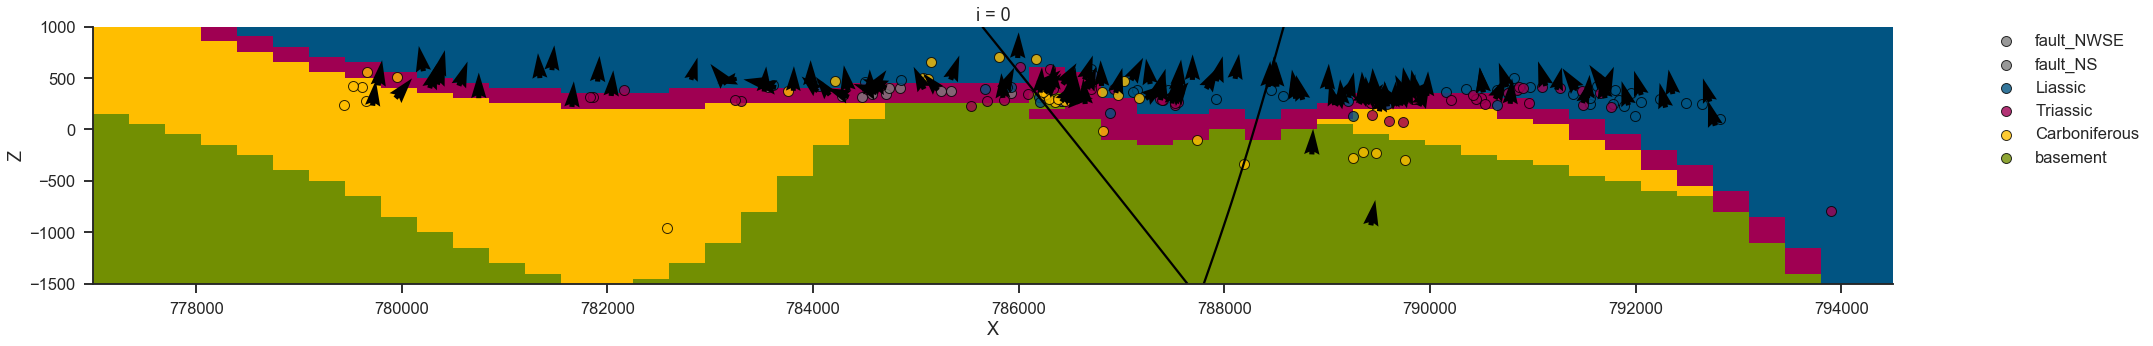

In [67]:
for i in range(0,2):
    post.plot_section(iteration=i,block='lith',fault=True,plot_data=True)
    plt.title("i = %.d"%i)
    #plt.savefig("C:\\Users\\elisa\\Documents\\git\\elthesis\\fig_export2\\entropy_orient"+str(i))

In [ ]:
post = Posterior(dbname,entropy=True,interpdata=interp_data,geodata=geo_data)

#### Topography

In [9]:
#topography
path_dtm='C:\\Users\\elisa\\Documents\\Ales\\DISTRIB_2018\\MNT\\MNT_Dx25m_ALES_L93.asc'
folder= "C:\\Users\\elisa\\Documents\\git\\MSc\\GempyTopography\\unwichtig"
xyz_path = "C:\\Users\\elisa\\Documents\\git\\MSc\\GempyTopography\\XYZ.csv"

In [10]:
from gempy.utils import topography

In [11]:
elevation = topography.DEM(path_dtm, geo_data,output_path = folder)

Extents of geo_data and DEM do not match. DEM is cropped and stored as C:\Users\elisa\Documents\git\MSc\GempyTopography\unwichtig_cropped_DEM.tif


Raster extent: [ 777000  794500 6345000 6353000     138     730] 
Raster resolution: [320 700]


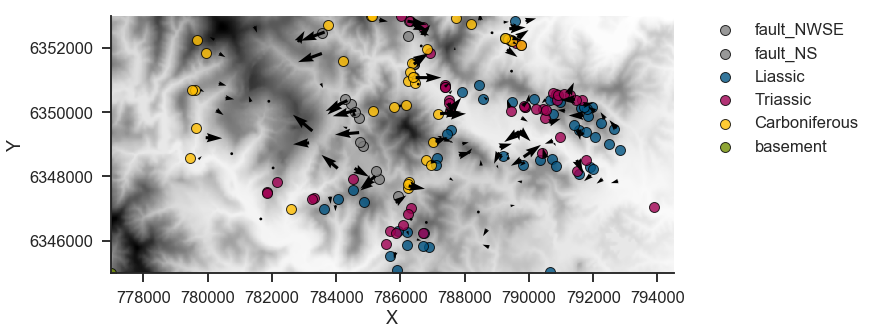

In [12]:
elevation.show(plot_data=True)

In [10]:
interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  dtype='float64',theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2


In [11]:
lith_block, fault_block = gp.compute_model(interp_data)

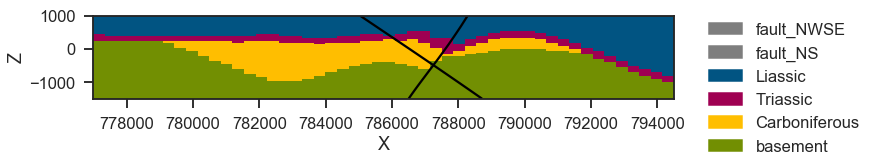

In [12]:
gp.plot_section(geo_data, lith_block[0], cell_number=5,  direction='y')#, topography=elevation)
gp.plotting.extract_countours(geo_data,interp_data,fb=fault_block,cell_number=5,direction='y')

In [ ]:
lith_map, fault_map = gp.compute_model_at(elevation.surface_coordinates[0], interp_data)

In [ ]:
lith_map[0].reshape(324, 588)

In [ ]:
gp.plotting.plot_map(geo_data, geomap=np.flip(lith_map[0].reshape(324, 588),axis=0),plot_data=True)
gp.plotting.extract_countours(geo_data,interp_data, fb=fault_map, lb=lith_map)

In [99]:
geo_data.resolution

array([30, 30, 30])

In [21]:
ver , sim = gp.get_surfaces(interp_data,lith_block[1],(fault_block[1], fault_block[3], fault_block[5]))

In [22]:
gp.plotting.plot_surfaces_3D(geo_data, ver, sim, plot_data=False)

closing vtk
